In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [4]:
# Load the dataset
df = pd.read_csv('../data/stroke_dataset.csv')

In [99]:
# look at the dataset
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [100]:
# some of these variables are categorical, so we need to convert them to numerical values before we can perform the imputation
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [101]:
np.random.seed(91) # for reproducibility

# Perform Little’s MCAR test, which tests the null hypothesis that the data is Missing Completely at Random (MCAR)
mt = MCARTest(method="little")
p_value = mt.little_mcar_test(df)

print(f"Little’s MCAR test p‑value: {p_value:.4f}") # just to see the p-value, we'll print it here

if p_value > 0.05: # if the p-value is greater than 0.05, we fail to reject the null hypothesis, which means that the data is likely MCAR
    print("MCAR cannot be rejected")
else:
    print("Data is likely not MCAR")

Little’s MCAR test p‑value: 0.0000
Data is likely not MCAR


In [102]:
# We will proceed with using MICE imputation. This may be quite a lot of predictors, and runs the risk of overfitting
# If the data performs poorly on the test, we may want to consider using a simpler imputation method, such as mean imputation, or using fewer predictors in the MICE imputation.
columns_to_impute = ['bmi', 'age', 'avg_glucose_level', 
                     'gender_Male', 'gender_Female',
                     'ever_married_Yes', 'ever_married_No', 
                     'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'work_type_Govt_job', 'work_type_Never_worked',
                     'Residence_type_Urban', 'Residence_type_Rural', 
                     'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes',
                     'stroke']

# make a dataframe with only the columns we want to use as predictors for the imputation
data_for_imputation = df[columns_to_impute]

imputer = IterativeImputer(
    random_state=91,      # for reproducibility
    max_iter=10,          # number of MICE iterations
    sample_posterior=True # adds stochasticity for multiple imputation
)

# Fit the imputer and transform the data
imputed_array = imputer.fit_transform(data_for_imputation)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=columns_to_impute)

In [ ]:
# check the imputed dataframe
imputed_df['bmi_original'] = df['bmi'].copy() # add the original bmi column for comparison
print(imputed_df[['bmi', 'bmi_original']]) # just to see the imputed bmi values compared to the original bmi values, we'll print them here

# create a mask to identify which values were imputed (i.e., which values were originally missing) 
imputed_mask = imputed_df['bmi_original'].isna()

            bmi  bmi_original
0     36.600000          36.6
1     36.296974           NaN
2     32.500000          32.5
3     34.400000          34.4
4     24.000000          24.0
...         ...           ...
5105  26.607766           NaN
5106  40.000000          40.0
5107  30.600000          30.6
5108  25.600000          25.6
5109  26.200000          26.2

[5110 rows x 2 columns]


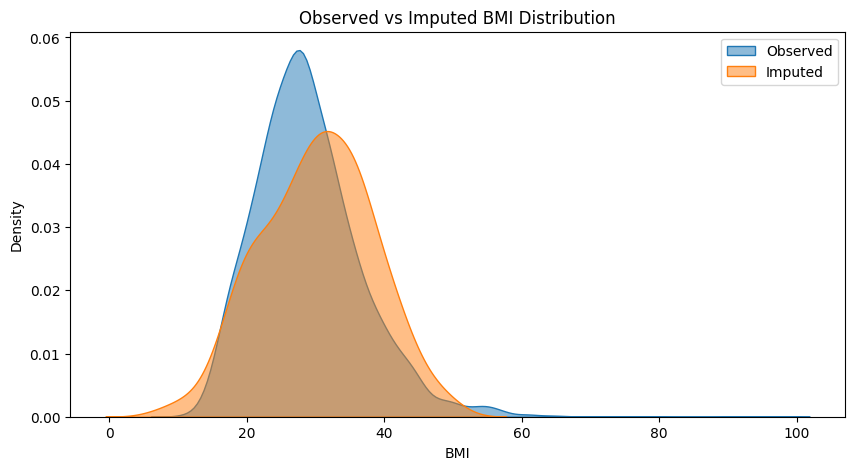

In [ ]:
# we will be making a KDE plot here to compare the distribution of the originaal vs imputed bmi values
plt.figure(figsize=(10,5))

# plotting both the observed and imputed bmi distributions on the same plot for comparison
sns.kdeplot(imputed_df.loc[~imputed_mask, 'bmi'], label='Observed', fill=True, alpha=0.5)
sns.kdeplot(imputed_df.loc[imputed_mask, 'bmi'], label='Imputed', fill=True, alpha=0.5)

# labelling and titling the graph for readability
plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('Observed vs Imputed BMI Distribution')
plt.legend()
plt.show()

# the output suggests that the imputed bmi values have a similar distribution to the observed bmi values, 
# which is a good sign that the imputation has been successful in capturing the underlying distribution of the data.
# always be careful of overfitting, though.

# NOTE FOR FUTURE WORK:
# I wrote all this to get it out of the way, but ideally we would be doing all of this AFTER the train-test split.
# We want to avoid data leakage here. Otherwise, consider the data totally cleaned and ready for use.